In [1]:
!pip install facenet-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alfredhhw/adiencegender")

print("Path to dataset files:", path)

Resuming download from 1048576 bytes (2814137933 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/alfredhhw/adiencegender?dataset_version_number=1 (1048576/2815186509) bytes left.


100%|██████████| 2.62G/2.62G [02:25<00:00, 19.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alfredhhw/adiencegender/versions/1


In [2]:
IMAGE_DIR = path + "/AdienceGender/aligned/"

In [3]:
import os
import re
import numpy as np
import pandas as pd
import torch
from PIL import Image
import cv2
from facenet_pytorch import MTCNN
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.manifold import TSNE

In [4]:
adience_df = pd.read_csv("https://drive.google.com/uc?id=11a8GW8PXR5jYWQCb73-7IzOTYUR6abQc&export=download")

In [5]:
adience_df

,image_path,age
0,30601258@N03/landmark_aligned_face.1.103996468...,"(25, 32)"
1,30601258@N03/landmark_aligned_face.2.104248158...,"(25, 32)"
2,30601258@N03/landmark_aligned_face.1.104379798...,"(25, 32)"
3,30601258@N03/landmark_aligned_face.3.104379798...,"(25, 32)"
4,30601258@N03/landmark_aligned_face.2.118166449...,"(25, 32)"
...,...,...
13963,101515718@N03/landmark_aligned_face.2280.10587...,"(25, 32)"
13964,101515718@N03/landmark_aligned_face.2278.10587...,"(25, 32)"
13965,101515718@N03/landmark_aligned_face.2279.10587...,"(25, 32)"
13966,50458575@N08/landmark_aligned_face.2281.942669...,"(25, 32)"


In [6]:
adience_df['image_path'] = adience_df['image_path'].astype(str)
adience_df['age'] = adience_df['age'].apply(eval)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
mtcnn = MTCNN(image_size=224, select_largest=True, keep_all=True, device=device)

In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3, interpolation=3, fill=0),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [10]:
adience_df = adience_df[adience_df['age'] != (8, 23)]

In [11]:
sorted(adience_df["age"].unique())

[(0, 2), (4, 6), (8, 12), (15, 20), (25, 32), (38, 48), (48, 53), (60, 100)]

In [12]:
class AdienceDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.age_range_to_index = {
            age_range : idx
            for idx, age_range in enumerate(sorted(self.dataframe["age"].unique()))
        }

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = row["image_path"]
        label = self.age_range_to_index[row["age"]]
        label = torch.tensor(label, dtype=torch.long)

        image = Image.open(IMAGE_DIR + image_path)
        image = image.resize((224, 224))

        faces, _ = mtcnn.detect(image)

        if faces is None:
            image = Image.open(IMAGE_DIR + image_path)
            image = image.resize((224, 224))
        else:
            largest_face_box = faces[0]
            image = image.crop((largest_face_box[0], largest_face_box[1], largest_face_box[2], largest_face_box[3]))

        if self.transform:
            image = self.transform(image)

        return image, label

In [13]:
dataset = AdienceDataset(adience_df, transform=transform)

train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [14]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [15]:
num_classes = 8

In [16]:
# model = models.efficientnet_b0(pretrained=True)
# num_ftrs = model.classifier[-1].in_features
# model.classifier[-1] = nn.Linear(num_ftrs, num_classes)

In [17]:
# model = models.vgg16(pretrained=True)
# num_ftrs = model.classifier[-1].in_features
# model.classifier[-1] = nn.Linear(num_ftrs, num_classes)

In [18]:
# model = models.densenet121(pretrained=True)
# model.classifier = nn.Linear(model.classifier.in_features, num_classes)

In [22]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 12)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 113MB/s]


In [23]:
model = model.to(device)

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)  # Total loss across all samples
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = running_loss / len(train_loader.dataset)  # Average loss per sample
    train_accuracy = 100 * correct_train / total_train

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

print("Training complete.")

Epoch [1/5], Training Loss: 1.6148, Training Accuracy: 42.16%
Epoch [2/5], Training Loss: 1.3946, Training Accuracy: 48.46%
Epoch [3/5], Training Loss: 1.3348, Training Accuracy: 49.49%
Epoch [4/5], Training Loss: 1.3148, Training Accuracy: 50.87%
Epoch [5/5], Training Loss: 1.2981, Training Accuracy: 51.32%
Training complete.


In [27]:
model.eval()

correct_test = 0
total_test = 0

all_predictions = []
all_labels = []


with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        _, predicted = torch.max(outputs, 1)

        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


# Calculate and print the final test accuracy
test_accuracy = 100 * correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.2f}%')

conf_matrix = confusion_matrix(all_labels, all_predictions)

precision, recall, f1_score, support = precision_recall_fscore_support(all_labels, all_predictions)

print("Confusion Matrix:\n", conf_matrix)
print("\nPrecision per class:", precision)
print("Recall per class:", recall)
print("F1-score per class:", f1_score)
print("Samples per class:", support)


Test Accuracy: 51.11%
Confusion Matrix:
 [[ 519   68    9    4   34    6    0    0]
 [ 116  184   30   14   95   15    1    0]
 [  35   65   72   22  227   45    3    0]
 [   3   18   11   70  178   40    8    0]
 [  22   26   27   34 1039  178   21    0]
 [   9    5    9    9  271  183   18    0]
 [   1    1    5    3   86   87   38    0]
 [   2    3    2    2   44   82   24    5]]

Precision per class: [0.73408769 0.4972973  0.43636364 0.44303797 0.52634245 0.28773585
 0.33628319 1.        ]
Recall per class: [0.8109375  0.4043956  0.15351812 0.21341463 0.77134373 0.36309524
 0.1719457  0.0304878 ]
F1-score per class: [0.77060134 0.44606061 0.22712934 0.28806584 0.62571515 0.32105263
 0.22754491 0.0591716 ]
Samples per class: [ 640  455  469  328 1347  504  221  164]


In [ ]:
feature_extractor = torch.nn.Sequential(*(list(model.children())[:-1]))
features = []
labels = []
with torch.no_grad():
    for images, label in test_loader:
        images = images.to(device)
        outputs = feature_extractor(images)
        features.append(outputs.view(outputs.size(0), -1).cpu())
        labels.append(label.cpu())

features = torch.cat(features, dim=0).numpy()
labels = torch.cat(labels, dim=0).numpy()

tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(features)


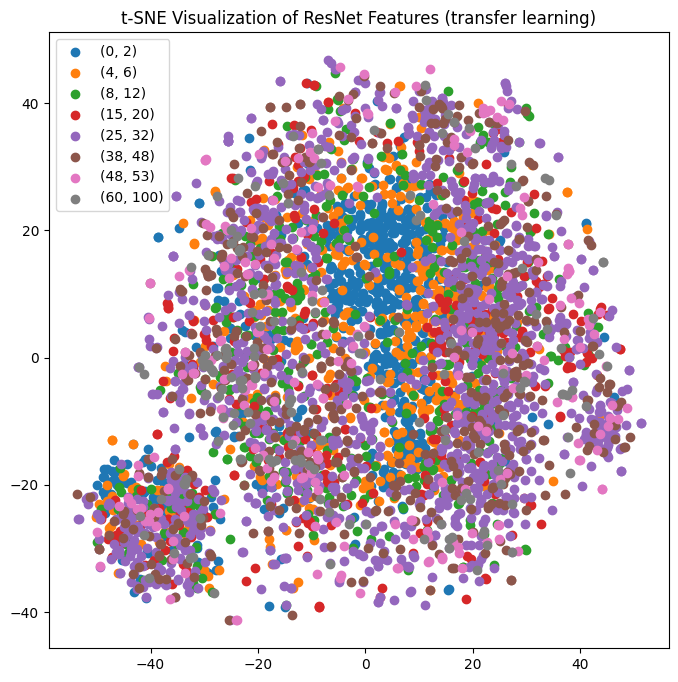

In [39]:
plt.figure(figsize=(8, 8))
for label in set(labels):
    plt.scatter(
        reduced_features[labels == label, 0],
        reduced_features[labels == label, 1],
        label=next(key for key, value in dataset.age_range_to_index.items() if value == label)
    )
plt.legend()
plt.title("t-SNE Visualization of ResNet Features (transfer learning)")
plt.show()